In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

### 1.  Bộ dữ liệu ARE Historical Data

In [2]:
df = pd.read_csv('ARE-Historical-Data-2015.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,115.37,113.04,116.30,113.04,969.55K,2.67%
1,06/01/2023,112.37,112.58,113.00,110.88,733.80K,-0.96%
2,05/31/2023,113.46,112.31,113.87,111.56,2.35M,0.84%
3,05/30/2023,112.51,112.35,113.58,111.64,843.18K,0.66%
4,05/26/2023,111.77,111.93,112.44,110.68,865.88K,0.49%
...,...,...,...,...,...,...,...
2113,01/09/2015,93.36,92.86,94.03,89.75,407.26K,-0.29%
2114,01/08/2015,93.63,92.57,93.85,92.43,718.78K,1.15%
2115,01/07/2015,92.57,91.55,92.57,90.69,543.40K,1.36%
2116,01/06/2015,91.33,90.65,91.56,90.25,1.33M,0.51%


In [3]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,115.37
1,112.37
2,113.46
3,112.51
4,111.77
...,...
2113,93.36
2114,93.63
2115,92.57
2116,91.33


In [4]:
df.isnull().sum()

Price    0
dtype: int64

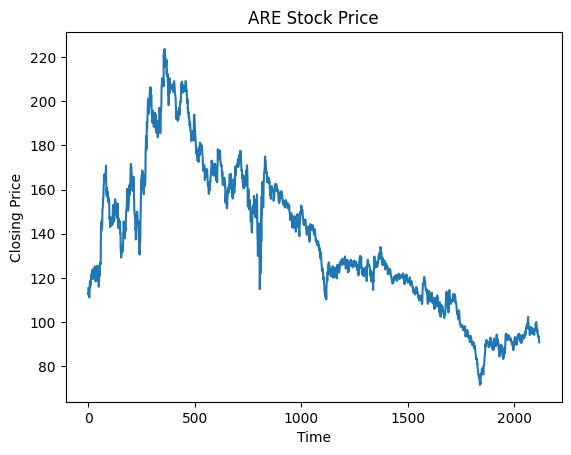

In [5]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [6]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.254811
p-value: 0.649584
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

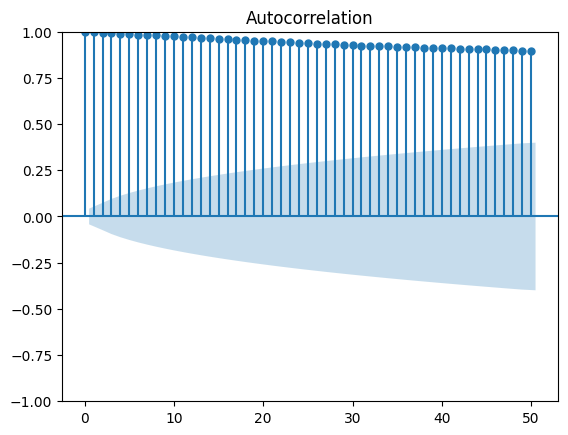

In [7]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [8]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [9]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [10]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [11]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1482    120.004132
1483    120.352479
1484    120.050816
1485    119.855752
1486    120.062727
1487    119.450901
1488    120.204985
1489    120.258850
1490    120.031594
1491    120.477763
1492    120.314466
1493    119.966016
1494    119.849784
1495    119.231525
1496    119.188853
1497    118.940584
1498    118.951385
1499    118.809980
1500    118.541071
1501    118.955431
1502    118.732838
1503    119.067095
1504    118.961442
1505    119.338946
1506    120.008709
1507    119.967466
1508    119.889343
1509    120.025293
1510    120.400314
1511    120.165963
dtype: float64


In [12]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 27.417704613905915
Testing RMSE: 21.421999724945483


Validation RMSE: 27.417704613905915
Testing RMSE: 21.421999724945483


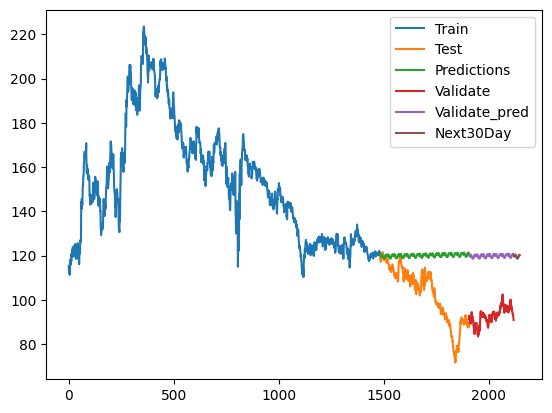

In [13]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 2.  Bộ dữ liệu ARI Historical Data

In [14]:
df = pd.read_csv('ARI-Historical-Data-2015.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,10.73,10.52,10.79,10.42,1.02M,3.67%
1,06/01/2023,10.35,10.14,10.40,9.97,994.05K,2.58%
2,05/31/2023,10.09,10.10,10.22,9.99,1.26M,-1.27%
3,05/30/2023,10.22,10.16,10.32,10.12,862.02K,0.59%
4,05/26/2023,10.16,9.91,10.21,9.79,877.78K,3.25%
...,...,...,...,...,...,...,...
2113,01/09/2015,16.41,16.48,16.51,16.37,365.45K,-0.49%
2114,01/08/2015,16.49,16.69,16.69,16.45,440.70K,-0.84%
2115,01/07/2015,16.63,16.48,16.65,16.44,492.81K,1.28%
2116,01/06/2015,16.42,16.60,16.64,16.37,225.81K,-0.55%


In [15]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,10.73
1,10.35
2,10.09
3,10.22
4,10.16
...,...
2113,16.41
2114,16.49
2115,16.63
2116,16.42


In [16]:
df.isnull().sum()

Price    0
dtype: int64

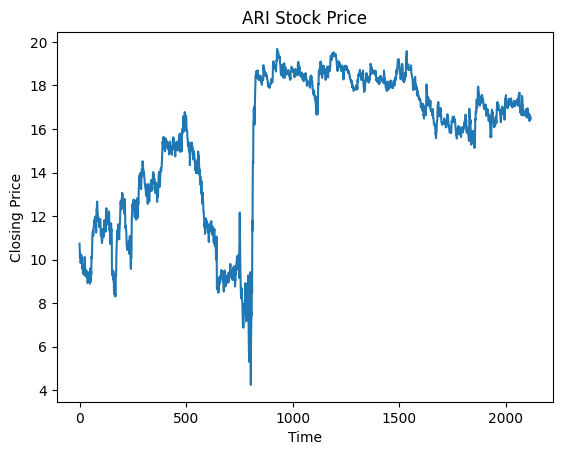

In [17]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df)
plt.title('ARI Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [18]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.218707
p-value: 0.199526
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

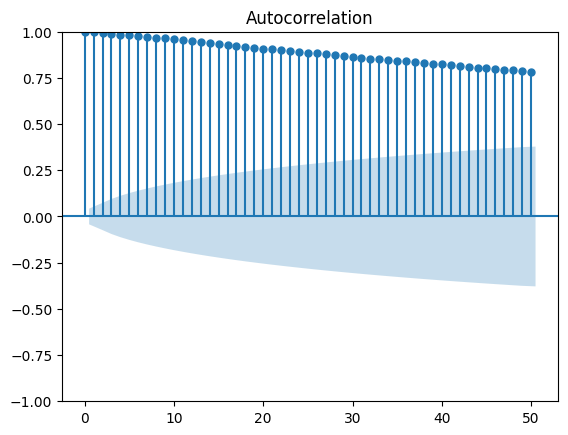

In [19]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [20]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [21]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [22]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [23]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1482    18.281015
1483    18.352457
1484    18.299803
1485    18.255506
1486    18.236338
1487    18.223075
1488    18.247355
1489    18.287766
1490    18.328397
1491    18.395321
1492    18.373700
1493    18.357996
1494    18.272065
1495    18.294111
1496    18.329619
1497    18.329003
1498    18.309611
1499    18.331249
1500    18.345521
1501    18.427519
1502    18.400114
1503    18.402109
1504    18.383517
1505    18.439111
1506    18.494091
1507    18.445900
1508    18.453496
1509    18.465684
1510    18.493482
1511    18.482288
dtype: float64


In [24]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 2.0181135306730718
Testing RMSE: 2.788400844449673


Validation RMSE: 2.0181135306730718
Testing RMSE: 2.788400844449673


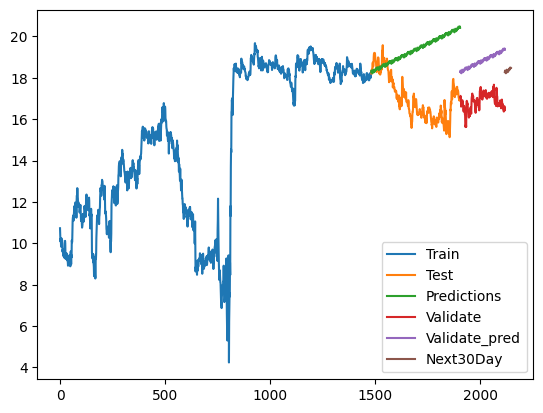

In [25]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()

### 3.  Bộ dữ liệu MAA Historical Data

In [26]:
df = pd.read_csv('MAA-Historical-Data-2015.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,150.66,148.38,151.02,148.10,602.20K,2.55%
1,06/01/2023,146.92,147.30,147.49,145.18,735.02K,-0.10%
2,05/31/2023,147.06,147.27,148.18,146.30,865.11K,-0.04%
3,05/30/2023,147.12,146.81,147.84,146.14,654.84K,0.79%
4,05/26/2023,145.96,144.49,146.45,143.73,576.67K,1.00%
...,...,...,...,...,...,...,...
2113,01/09/2015,78.83,78.37,79.37,77.98,481.35K,0.63%
2114,01/08/2015,78.34,78.14,78.46,77.36,544.03K,0.26%
2115,01/07/2015,78.14,76.48,78.34,76.29,544.77K,1.24%
2116,01/06/2015,77.18,76.28,77.83,76.27,833.74K,1.74%


In [27]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df

,Price
0,150.66
1,146.92
2,147.06
3,147.12
4,145.96
...,...
2113,78.83
2114,78.34
2115,78.14
2116,77.18


In [28]:
df.isnull().sum()

Price    0
dtype: int64

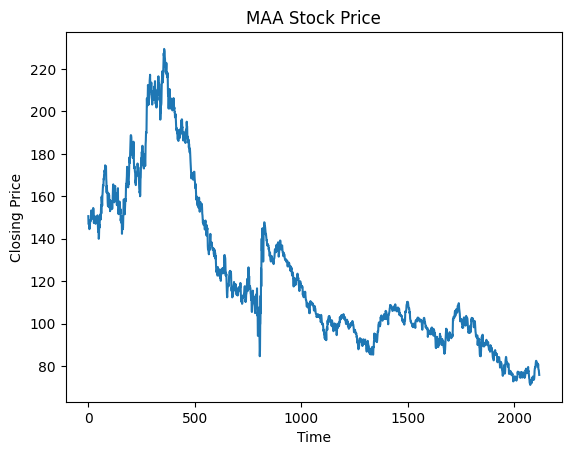

In [29]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

* Nhìn vào biểu đồ, chúng ta có thể thấy rằng giá đóng cửa của ARE có xu hướng tăng theo thời gian, nhưng đồng thời cũng có những biến động và dao động lớn. Điều này cho thấy dữ liệu không ổn định và có thể cần được xử lý trước khi sử dụng trong mô hình Holt-Winters.

In [30]:
# Sử dụng ADF (Augmented Dickey-Fuller) test để kiểm tra tính ổn định của dữ liệu
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.932891
p-value: 0.776948
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


* Kết quả cho thấy p-value > 0.05 => dữ liệu không ổn định

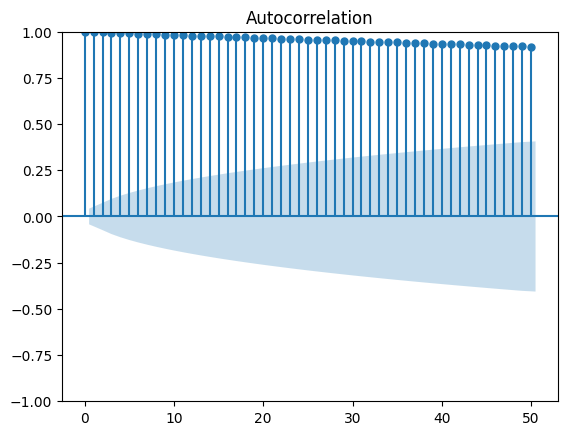

In [31]:
#Kiểm tra tính chu kỳ của dữ liệu
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=50)
plt.show()

* Nhìn đồ thị ta thấy dữ liệu không có tính chu kỳ rõ ràng

Vậy dữ liệu ARE Historical Data ban đầu không phù hợp cho mô hình Holt-winters

In [32]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [33]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the model
model = ExponentialSmoothing(train_data, seasonal_periods=30, trend='add', seasonal='add').fit()

In [34]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.forecast(len(x_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.forecast(len(x_val))

In [35]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1482    100.630034
1483    100.932971
1484    100.781686
1485    100.514148
1486    100.494875
1487     99.923715
1488    100.483277
1489    100.360945
1490     99.759933
1491    100.096758
1492     99.952946
1493     99.864732
1494     99.683821
1495     99.289017
1496     99.176415
1497     99.227611
1498     99.134316
1499     99.217192
1500     98.870041
1501     99.255805
1502     98.937183
1503     99.220269
1504     99.081850
1505     99.338628
1506     99.418652
1507     99.447790
1508     99.392965
1509     99.529035
1510     99.890539
1511     99.386197
dtype: float64


In [36]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 18.760494012707884
Testing RMSE: 6.785125377714043


Validation RMSE: 18.760494012707884
Testing RMSE: 6.785125377714043


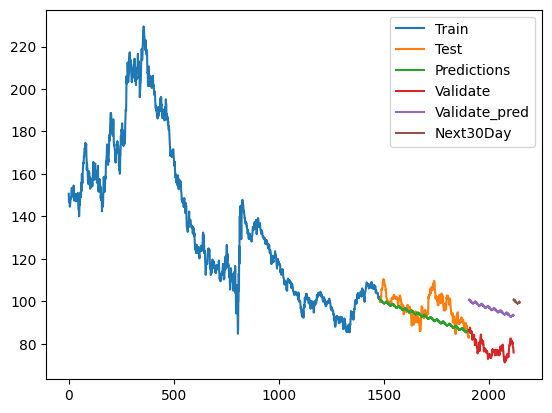

In [37]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate', 'Validate_pred','Next30Day'])
plt.show()